### CS/ECE/ISyE 524 &mdash; Introduction to Optimization &mdash; Spring 2023 ###

### Final Course Project: Due 5/5/23

# Scheduling a To-Do List with Task Dependencies and Deadlines #

**To see images, go to [my project on GitHub](https://github.com/lauren-ciha/intro-to-optimization-final-project/blob/main/project_report.ipynb)**

#### Lauren Ciha lciha@wisc.edu

*****

### Table of Contents

1. [Introduction](#1.-Introduction)
1. [Mathematical Model](#2.-Mathematical-model)
1. [Solution](#3.-Solution)
1. [Results and Discussion](#4.-Results-and-discussion)
1. [Conclusion](#5.-Conclusion)

## 1. Introduction ##

To-do lists are great for keeping track of what you need to do. But they rarely tell you what to do when.

Take my to-do list for example. Here are some of my weekly tasks this semester:

![todolist.png](todolist.png)

Each task has a deadline and an estimation of how long it will take to complete it. Notice that one of these tasks has a subtask.

![subtask.png](subtask.png)

For this assignment, I prefer to print out the worksheet, fill it out, and then upload it as a pdf. In order to do my 577 homework assignment, then, I need to *first* print out the worksheet. We could say that doing my 577 homework depends on printing out the homework sheet. In optimization speak, my 577 homework task has a dependency.

In addition, I can't do my homework all day every day, so I have to choose which tasks I do each day carefully. If I spend my time Monday working on something that isn't due until later in the week, I could miss the deadline for another assignment.

**This project outlines a model that will tell me which tasks I should do on each day of the week given each task's dependencies, expected duration, deadline, and the amount of time I have to do homework each day.**

In the **Mathematical Model section**, I turn this problem into equations. More specifically, I explain how my to-do list problem can be formulated as a Generalized Assignment Problem (GAP) and outline the model's decision variables, constraints, and objective function.

With these equations, I can have a computer solve this problem for me. In the **Code section**, I show what my model can look like in the JuMP and Julia languages.

Once we have our output from the computer solver, I then explain what these results mean and the limitations of my model in the **Results and Discussion section** (turns out planning out your week is more complicated than I thought!).

Finally, in the **Conclusion section** I explain next steps for turning my daily to-do lists into one to-do list for the entire week. (Spoiler alert: more models!)

## 2. Mathematical model ##

### Generalized Assignment Problem (GAP)

My to-do list scenario falls under the category of the generalized assignment problem (GAP). In a generalized assignment problem, the goal is to match one set of items to another, given certain constraints. In this problem, we want to match tasks to days of the week. 

Generalized Assignment Problems are a kind of integer program because we are forcing our assignments to have integer values. For example, in this program, there isn't a range of values between days of the week: it's either Monday or Tuesday or Wednesday and so on.


### Assumptions

**For this problem, I will assume that:**
* I know the amount of time it will take me to complete each task.
* I only have a certain amount of time available each day to work on tasks.
* I can only do one task at a time.
* I am doing each task in one and only one sitting.
* There is no travel time or break time needed between tasks.
* Some, but not all, tasks depend on other tasks.

**Before we jump into the decision variables, constraints, and objective, let's get some notation out of the way:**
* Let $\mathcal{T}$ be the set of tasks to complete.
* Let $\mathcal{D}$ be the set of days for the tasks to be completed in.
* Let $\mathcal{P}$ be the set of tasks that are the ancestors of a given task. In other words, $\mathcal{P}_j$ contains the tasks that j depends on.
* Let $\text{durations}_i$ be the set of task durations for a task i.
* Let $\text{available_work_time}$ be the set of times (in minutes) that I can work each day in $\mathcal{D}$.
* Let $\text{deadlines}_i$ be the set of deadlines for each task in $\mathcal{T}$


### Decision Variables 

For this model, we need to decide which day a task will be done. We can represent this choice with a binary variable $d$ in a $|\mathcal{T}|$ x $|\mathcal{D}|$ matrix such that:

$ d_{i \in \mathcal{T}, j \in \mathcal{D}} = \begin{cases}
1 \quad \text{if task i is completed on day j} \\
0 \quad \text{otherwise}
\end{cases}$

The model will generate a $d$ matrix where we can figure out the task-day assignments by seeing which values are 1.

### Constraints


#### Simple constraints:

* Each task must be assigned a day and only one day: $\quad\sum_{j \in \mathcal{D}} d_{ij} = 1$
* The time needed to complete all the tasks in one day cannot exceed the day's available work time: $\quad\sum_{i \in \mathcal{T}, j \in \mathcal{D}} d_{ij}*\text{durations}_{i} \le \text{available_work_time}_j$


#### Boolean constraints

The next two constraints are a bit more complicated because they include boolean logic.

##### Deadline constraint

* Each task must be completed before its deadline:
    We can phrase this constraint as "if $j > deadline_i$, then $d_{ij} = 0$". Using rules from logical constraints, we can write the constraint as the formula:
    
    for $i \in \mathcal{T}$ and $j \in \mathcal{D}$, $j - deadlines_i \le M(1 - d_{ij})$, where $M$ is $|\mathcal{D}|$ - 1

We can see why this works in the following example:

*Case 1: task i's day done j is before i's deadline:*

Suppose $deadlines_i = 2, j = 1 $
    
$-1 \le M(1 - d_{ij})$
    
When $d_{ij} = 1$, the right hand side is 0. When $d_{ij} = 0$, the right hand side is M. In both cases, the inequality holds, so $d_{ij}$ could be 0 or 1.
    
*Case 2: task i's day done j the same as i's deadline:*

Suppose $deadlines_i = j = 2 $

$ 0 \le M(1-dij) $

When $d_{ij} = 1$, the right hand side is 0. When $d_{ij} = 0$, the right hand side is M. Like the case above, the inequality holds in both choices for $d_{ij}$, so $d_{ij} $ could be 0 or 1.
    
*Case 3: task i's day done j is after i's deadline:*

Suppose $deadlines_i = 2, j = 3$

$1 \le M(1-d_{ij}) $ 
    
When $d_{ij} = 0$, the right hand side is M, so the inequality holds. However, when $d_{ij} = 1$, that yields $ 1 \le 0 $, which is an invalid inequality. Therefore, when we set the constraint $ 1 \le 1(1-d_{ij}) $, we force $d_{ij}$ to be zero whenever j is greater than k. As a result, this formula captures the logical constraint in our problem.

##### Precedence constraints

* A task with a precendence constraint cannot occur on a day before its preceding task is done. In other words, if task p precedes q and p occurs on day k, $d_{qj} = 0$ where $j < k$.

We can split the above constraint into two parts:

**Part one: $d_{qj} = 0$ if $k > j$, where task p precedes q, p occurs on day k, and j is the day task q is done.**

Since it's challenging to model strict inequalities as logical constraints, we will use the contrapositive:
* if $d_{qj} = 1$, then $k \le j$ where task p precedes q, p occurs on day k, and q occurs on day j.

Here, we can apply a similar logic rule to the one in the deadline constraint to get:

for $i \in \mathcal{T}$ and $j \in \mathcal{D}, k - j <= M(1-d_{ij})$, where $M$ is $|\mathcal{D}|$ - 1.

This equation forces $d_{ij}$ to be 0 whenever k > j while letting $d_{ij}$ be 0 or 1 when $k \le j$.

**Part two: if p precedes q**

We can create a constraint $z_{pq}$ in a $|\mathcal{T}|$ x $|\mathcal{T}|$ matrix such that:

$ z_{p \in \mathcal{T}, q \in \mathcal{T}} = \begin{cases}
1 \quad \text{if task p must precede task q} \\
0 \quad \text{otherwise}
\end{cases}$

The $z$ values are set based on the precedence table given.

The key now is to incorporate this z value into the constraint we found above. We can write the logic of the entire precedence constraint as follows:

If task p must precede q and p occurs on day k, $d_{qj} = 0$ where $j < k$.

$\Leftrightarrow$ If $z_{pq} = d_{pk} = 1$, then $k - j \le M(1-d_{qj})$ (part one of this constraint)

Since our if statement's antecedent is $z_{pq} = d_{pk} = 1$, we can add $z_{pq}$ to the subtractions in the previous constraint and then translate the whole if statement into a formulaic constraint:

If $z_{pq} = d_{pk} = 1$, then $k - j \le M(1-d_{qj})$ (part one of this constraint)

can be translated to:

###### The set of precedence constraints:

$\forall p,q \in z, (k - j) - M(2-d_{qj}-z_{pq}) \le M(2-z_{pq}-d_{qj})$

where $M$ is $|\mathcal{D}|$ - 1.

We can show this models the constraint both when $z_{pq} = 1$ and 
when $z_{pq} = 0$.

Suppose $z_{pq} = 1$, $M$ and $|\mathcal{D}|$ - 1.

*Case 1: j (the day q is done) > k (for example, k = 1 and j = 2):*

$$
\begin{aligned} \\
&(1 - 2) - M(2-d_{qj}-1) \le M(2-1-d_{qj})\\
&-1 - M(1-d_{qj}) \le M(1-d_{qj}) \\
&\text{if } d_{qj} = 1: \\
&\qquad\qquad-1 - 0 \le 0 \quad\text{(satisfies inequality)}\\
&\text{if } d_{qj} = 0 \\
&\qquad\qquad-1 - M \le M \quad\text{(satisfies inequality)}\\
\end{aligned}
$$

Since the left hand side will be a negative number minus $M$, $d_{qj}$ can be 0 or 1 whenever j > k.

*Case 2: j (the day q is done) < k (for example, k = 2 and j = 1):*

$$
\begin{aligned} \\
&(2 - 1) - M(2-d_{qj}-1) \le M(2-1-d_{qj})\\
&1 - M(1-d_{qj}) \le M(1-d_{qj}) \\
&\text{if } d_{qj} = 1: \\
&\qquad\qquad1 - 0 \le 0 \quad\text{(cannot satisfy inequality)}\\
&\text{if } d_{qj} = 0: \\
&\qquad\qquad1 - M \le M \quad\text{(satisfies inequality)}\\
\end{aligned}
$$

Since in this case k - j is always positive, the only way to satisfy the inequality is to set $d_{qj}$ to 0. In other words, this equation forces $d_{qj}$ to 0 whenever j < k (whenever a task could occur on the day before its preceding task is done).

*Case 3: j (the day q is done) = k (for example, k = j = 2)*

$$
\begin{aligned} \\
&(2 - 2) - M(2-d_{qj}-1) \le M(2-1-d_{qj}) \\
&0 - M(1-d_{qj}) \le M(1-d_{qj}) \\
&\text{if } d_{qj} = 1: \\
&\qquad\qquad0 \le 0 \quad\text{(satisfies inequality)}\\
&\text{if } d_{qj} = 0 \\
&\qquad\qquad-M \le M \quad\text{(satisfies inequality)}\\
\end{aligned}
$$

Since we will always get a situation where $-M <= M, d_{qj}$ can be 0 or 1 whenever a task and its preceding task are done on the same day. One limitation of this model is that it cannot put tasks in absolute order, just assign tasks to days in a way that satisfies the precedence constraints.
           
A similar exercise can show that the formula satisifes the constraint when $z_{pq} = 0$. For brevity, I will just give the inequalities for the three cases with $z_{pq} = 0$ and $M$ = $|\mathcal{D}|$ - 1. When $z_{pq} = 0$, $d_{pq}$ can be either 0 or 1 in all three cases.

*Case 1: j (the day q is done) > k (for example, k = 1 and j = 2)*

$$
\begin{aligned}
&\text{(a negative number)} - M(2-d_{pq}) \le M(2-d_{pq})
\end{aligned}
$$

*Case 2: j (the day q is done) < k (for example, k = 2 and j = 1)*

$$
\begin{aligned}
&\text{(a positive number)} - M(2-d_{pq}) \le M(2-d_{pq})
\end{aligned}
$$

*Case 3: j (the day q is done) = k (for example, k = j = 2)*

$$
\begin{aligned}
&0 - M(2-d_{pq}) \le M(2-d_{pq})
\end{aligned}
$$


### Objective

Any solution that satisfies the constraints provides a way to complete my tasks on time, but we can use an objective to influence the schedule provided. For example, in this problem I want to minimize procrastination, so we can write the objective as:

$\text{minimize} \sum d_{ij} * j \qquad \forall i \in \mathcal{T}, \quad \forall j \in \mathcal{D}$

This equation effectively minimizes procrastination because $d_{ij}$ is a binary variable (0 or 1) and we are indexing days with integers (Monday = 1, Tuesday = 2, etc.). Therefore, when we multiply each $d_{ij}$ by j, we will get a smaller summation if each task is completed earlier rather than later.


### Putting this all together, we can write the model as:
$$
\begin{aligned} \\
\text{minimize} \qquad& \sum d_{ij} * j \quad \forall i \in \mathcal{T}, \quad \forall j \in \mathcal{D} \\
& \sum_{j \in \mathcal{D}} d_{ij} = 1 \\
& \sum_{i \in \mathcal{T}, j \in \mathcal{D}} d_{ij} \le |\mathcal{T}| \\
& \sum_{i \in \mathcal{T}, j \in \mathcal{D}} d_{ij}*\text{duration}_{i} \le \text{available_work_time}_j \\
& \forall i \in \mathcal{T} \text{and } j \in \mathcal{D}, j - deadlines_i \le M(1 - d_{ij}) \\
& \forall p,q \in z, (k - j) - M(2-d_{qj}-z_{pq}) \le M(2-z_{pq}-d_{qj}) \\
& M = |\mathcal{D}| - 1
\end{aligned}
$$

$ d_{i \in \mathcal{T}, j \in \mathcal{D}} = \begin{cases}
1 \quad \text{if task i is completed on day j} \\
0 \quad \text{otherwise}
\end{cases}$

$ z_{p \in \mathcal{T}, q \in \mathcal{T}} = \begin{cases}
1 \quad \text{if task p must precede task q} \\
0 \quad \text{otherwise}
\end{cases}$




## 3. Solution ##

We can summarize the information in the to-do list in the following table:

| Task Name                    | Immediate Predecessors | Duration (minutes) |
|------------------------------|------------------------|--------------------|
| 524 homework                 | None                   |        360         |
| 577 homework                 | c                      |        60          |
| print off 577 homework sheet | None                   |        15          |
| 354 homework                 | None                   |        120         |
| 354 project                  | None                   |        360         |
| print off 354 notes sheet    | None                   |        15          |

### Data for the problem:

In [3]:
tasks = ["524 homework", "577 homework", "print off 577 homework sheet", "354 homework",
    "354 project", "print off 354 notes sheet"]

# duration is expressed in minutes (where tasks have a duration in 15 minute intervals)
durations = [ 3*60 60 15 120 6*60 15 ]

# pred stores ancestors on each task
pred = ( [], [3], [], [], [], [] )
num_tasks = length(tasks)

# deadlines for each task - 11:59pm that day is the same as <= deadline + 1
deadlines = [ 3 4 4 1 5 2 ]
    
# Day related data:
days = ["Monday", "Tuesday", "Wednesday", "Thursday", "Friday"]
    
# each entry corresponds to a day
available_work_time = [ 5*60 2*60 60 45 7*60]

num_days = length(days)

print()

### Code for Solution: 

In [4]:
using JuMP, HiGHS

m = Model(HiGHS.Optimizer)
set_silent(m)

# day integer variable where d[i,j] == 1 when task i is assigned to day j
@variable(m, d[1:num_tasks, 1:num_days], Bin)

# each task must be assigned a day and only one day
@constraint(m, r2[i=1:num_tasks], sum( d[i,j] for j=1:num_days) == 1)

# the time to complete all tasks in a day can't exceed work time per day
[ @constraint(m, sum(d[i,j]*durations[i] for i=1:num_tasks) <= available_work_time[j]) for j=1:num_days ]

# enforce precedence constraints in d - a task q that follows p cannot happen on a day before p is done
for q=1:num_tasks, p in pred[q]
    for j=1:num_days
        if (d[p,j] == 1)
            for k=1:j-1
                @constraint(m, d[q,k] == 0)
            end
        end
    end
end

# meet deadlines
[ @constraint(m, d[i,j] == 0) for i=1:num_tasks, j=1:num_days if j > deadlines[i]]

# we want to prevent procrastination, so we are going to minimize the last day that all the tasks can be done
@objective(m, Min, sum( d[i,j]*j for i=1:num_tasks, j=1:num_days))

optimize!(m)

D = value.(d)

# dictionary with days and tasks
plan = []
# task - day dictionary
task_assignment = []

for j=1:num_days
    println(days[j],": ")
    day = []
    for i=1:num_tasks
        if (D[i,j] == 1)
            println("\t",tasks[i])
            push!(day, tasks[i])
            push!(task_assignment, (tasks[i], days[j]))
        end
    end
    push!(plan, (days[j], day))
end
println()

Monday: 
	524 homework
	354 homework
Tuesday: 
	577 homework
	print off 577 homework sheet
	print off 354 notes sheet
Wednesday: 
Thursday: 
Friday: 
	354 project



## 4. Results and discussion ##

This model gives us a schedule for which tasks to do on which day to minimize procrastination and complete all tasks on time.

One interesting thing we can consider is how much of the available work time we use each day:

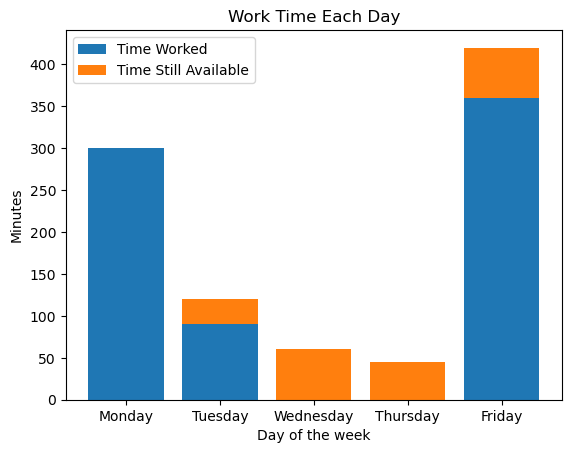

PyObject Text(0.5, 1.0, 'Work Time Each Day')

In [5]:
# How much time is allocated per day?
using PyPlot

total_work_time = []
above = []

for j=1:length(available_work_time)
    push!(total_work_time, sum( D[i,j]*durations[i] for i=1:num_tasks ) )
    push!(above, available_work_time[j] - sum( D[i,j]*durations[i] for i=1:num_tasks ) )
end

plt.bar(days, total_work_time, label="Time Worked")
plt.bar(days, above, bottom=total_work_time, label="Time Still Available")
plt.ylabel("Minutes")
plt.xlabel("Day of the week")

plt.legend()

plt.title("Work Time Each Day")

With this particular problem, the schedule utilizes all of Monday's available work time, most of Tuesday's available work time, and some of Friday's available work time. This makes sense because the objective function was designed to put as many tasks as early in the week as possible. The reason we are working on Friday at all is because that was the only day that had enough time to complete the entire 354 project in one sitting. Had there been more available work time earlier in the week, this task may have been scheduled on an earlier day. I say it may have been scheduled earlier because we also need to complete all the other tasks on time.

### Limitations

There are several limitations to the current model:

1. In real life, **we may not know how much time it will take to complete a task.** We could adjust our model to accommodate this by making the durations input a lower bound on projects. In order for the model to be feasible, we would have to provide some sort of upper bound. One such upper bound could be the deadline day minus the start day (in minutes). These new bounds may not be enough to enforce a task duration that's greater than what's provided, but would be the first step in capturing this real-life scenario.

2. Unlike in this model, **there may be several blocks of available work time per day**. To accommodate this constraint, we could make available work time an array of dictionaries, where the day (or day index is the key) and the value is an array of integers capturing the number of minutes for each chunk of work time.

3. Contrary to the model's constraints, **many tasks are done in more than one sitting**. We can factor in this complexity by allowing fractions of tasks to be done on a given day. If we create a continuous variable between zero and one that represents the fraction of the task done each day, we can adjust our current constraints so that one hundred percent of the task must be done by the deadline.

4. When scheduling a work day, **breaks happen, whether we want them to or not**. Some of the breaks could be captured by allowing multiple chunks of work time a day, but we also may want to take time to transition between tasks or pause on a current task. We can add in travel times between tasks into the sum of work time for a given work day or chunk of a work day. The way we'd incorporate breaks would depend on the kind of breaks taken. For example, if we allow for fractional task completion in a work session, we could add break time in if more than a certain percentage of a task is completed in a given time block. Similarly, if we want to take a break after a certain amount of time (regardless of which task is worked on), we can divide the total work time into sections and build in breaks accordingly.

## 5. Conclusion ##

This model assigns tasks to a number of work days based on task deadlines, the amount of time available to work, and task precedence constraints. What the model does not give is an absolute order to complete the tasks. 

Without an absolute ordering, someone would have to look at a task list for a given day and decide which tasks to complete when, which would require them to review the precedence constraints again.

To avoid this, **the next step for this model would be to solve a related problem given the $d$ table we have as output: Given a list of tasks to do on each day, precedence constraints, and deadlines, in what order should tasks be done in a given day?**

**There are two potential approaches to this problem:**

### The traveling salesman problem (TSP) ###

In the traveling salesman problem, we are given a list of cities to visit and the distances between them. The goal is to visit each city only once while minimizing the overall distance.

We can use the traveling salesman problem to solve our problem by solving TSP on each day of the week. The cities would be the tasks to do that day. Any precedence constraints could be added into the model. The distance between cities, however, could not be the duration of tasks, since the time needed to complete all tasks would be the same regardless of which order they were done in. One potential distance function could be the travel/transition time between tasks. Once we had a distance function and solved for an ordering for the tasks in each day, we could string those ordered lists together to make one grand to-do list.

While I believe this approach could work, one limitation to TSP as a model for this problem is that in TSP, the salesperson returns to the first city they start at. While this doesn't interfere with calculating the order of tasks per se, it complicates the process of putting the list of tasks in order. One way to overcome this limitation is to put a dummy "First/Last task" and assign that as the first/last "city" in the TSP. 

### Multi-period Planning Problem (MPP) ###

Another approach to solving this problem is to use the multiperiod planning problem as a model. In a multi-period planning problem, each task has a duration and precedence constraints and the objective is to put the tasks in order to minimize the overall time needed to complete all the tasks.

In my initial project formulation, I didn't have enough precedence constraints to cast the problem as a multi-period planning problem:

![mpp_before_optimizing.png](mpp_before_optimizing.png)

Now that we have assigned tasks to days, we can add the constraints that all tasks on the previous days must be done before completing the tasks on the current day:

![mpp_after_optimizing.png](mpp_after_optimizing.png)

These new constraints will help make the problem more of a multi-period planning problem, but there is still one key difference between my problem and a multi-period problem. In the multi-period planning problem, we assume that tasks that do not depend on each other can happen simultaneously. Maybe in the future ChatGPT can do my homework for me, but right now, I cannot do any two of these tasks simultaneously.

After attempting to model and code a solution to this follow-up problem with both problem formulations, I leave this as a follow-up to the model I've made. Getting a "grand plan" or completely ordered list is possible, but I need to meet this final project deadline.

I was surprised by how much work it took to model a planning process I do every week that requires much less mental effort. The work needed to mimic my planning process explains why I haven't seen an app that schedules tasks like these automatically. If we wanted a usable app that did this in the future, we'd need to not only account for the limitations in my model above, but allow it to reschedule and reassign tasks in the event of inevitable interruptions and planning miscalculations. I guess I could just start my homework earlier next time.

## Citations
“Can I make this Julia constraint one line: for j=1:length(available_work_time)
    @constraint(m, sum( d[i,j]*task_durations[i] for i=1:length(task_durations) ) <= available_work_time[j])
end” prompt. ChatGPT, 03 May version, OpenAI, 03 May 2023, chat.openai.com/chat.